In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%precision 4
%reload_ext autoreload
# Load the TensorBoard notebook extension.
%load_ext tensorboard

import re
import sys
import math
import random
import os
from datetime import datetime

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
import warnings


warnings.filterwarnings(action='once')
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

from IPython.core.pylabtools import figsize
figsize(20, 7)

### Target

Item sales for the month immediately after the data in sales_train.csv, which is November 2015:

DAILY_SALES=pd.read_csv('sales_train.csv')
DAILY_SALES['date_dt']=pd.to_datetime(DAILY_SALES['date'],format="%d.%m.%Y")
print(DAILY_SALES.date_dt.max())
> Timestamp('2015-10-31 00:00:00')

You want to predict the total sales for that month, i.e. one number for each shop/item pair in the test.csv file.

In [2]:
from pathlib import Path


BASE_DIR = Path("../input/predict_future_sales/")
print(os.listdir(BASE_DIR))

['item_categories.csv', 'items.csv', 'sales_train.csv', 'sample_submission.csv', 'shops.csv', 'test.csv']


In [3]:
items  = pd.read_csv(BASE_DIR / 'items.csv')
train = pd.read_csv(BASE_DIR / 'sales_train.csv')
test = pd.read_csv(BASE_DIR / 'test.csv')
item_category = pd.read_csv(BASE_DIR / 'item_categories.csv')
shops = pd.read_csv(BASE_DIR / 'shops.csv')

In [4]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [5]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
train['date'].min(), train['date'].max()

('01.01.2013', '31.12.2014')

In [7]:
train[(train.item_price < 0)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [8]:
# -1 and 307980 looks like outliers, let's delete them
print('before train shape:', train.shape)
train = train[(train.item_price > 0)]
print('after train shape:', train.shape)

before train shape: (2935849, 6)
after train shape: (2935848, 6)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b0f1e5f1048>]],
      dtype=object)

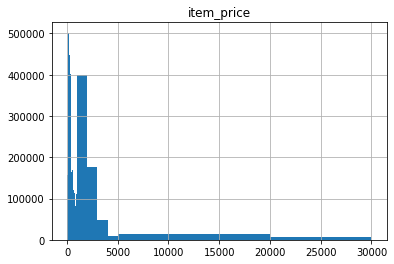

In [21]:
train[['item_price']].hist(bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 10000, 20000, 30000])

In [22]:
train['item_price_log1p'] = train.apply(lambda x: np.log1p(x['item_price']), axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b0f20103f98>,
      dtype=object)

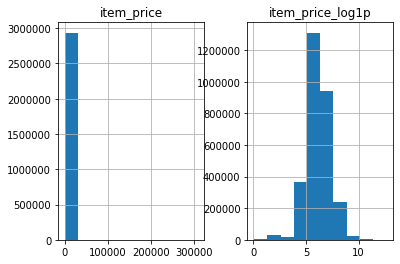

In [23]:
train[['item_price', 'item_price_log1p']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b78ababa4a8>,
      dtype=object)

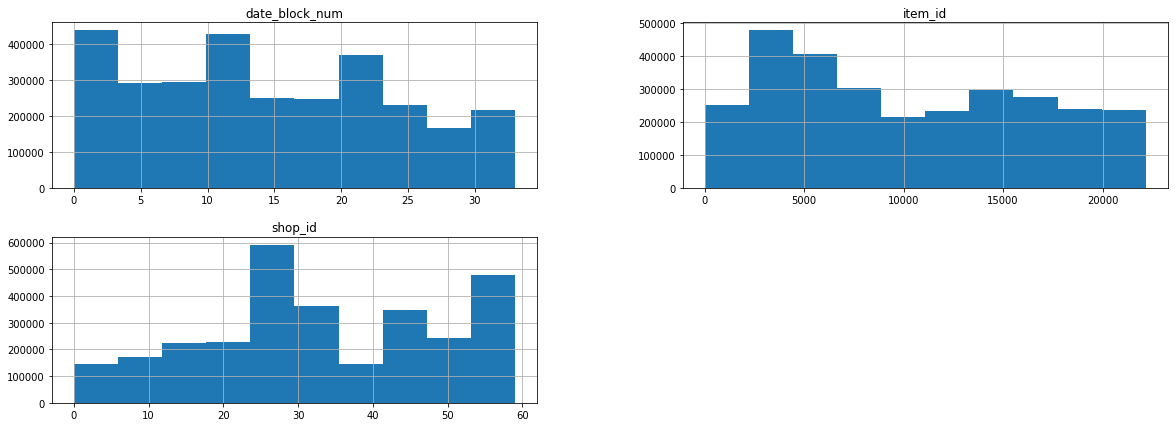

In [32]:
train[['date_block_num', 'shop_id', 'item_id']].hist()

In [24]:
item_category.head()

sum(item_category['item_category_id'].duplicated())

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


0

In [25]:
items.head()

sum(items['item_id'].duplicated())

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


0

In [26]:
item_to_cat_df = pd.merge(items, item_category, how="left", on="item_category_id")
item_to_cat_df.head()

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",1,76,Программы - Для дома и офиса (Цифра)
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
4,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD


In [27]:
train['date'] = pd.to_datetime(train.date,format="%d.%m.%Y")
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_price_log1p
0,2013-01-02,0,59,22154,999.00,1.0,6.907755
1,2013-01-03,0,25,2552,899.00,1.0,6.802395
2,2013-01-05,0,25,2552,899.00,-1.0,6.802395
3,2013-01-06,0,25,2554,1709.05,1.0,7.444278
4,2013-01-15,0,25,2555,1099.00,1.0,7.003065


### Trend

In [34]:
## Pivot by monht to wide format
p_df = train.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
p_df.head()

date_block_num     0     1    2    3    4    5    6    7    8    9   10   11  \
shop_id item_id                                                                
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        33       3.0  3.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

date_block_num    12   13   14   15   16   17   18   19   20   21   22   23  \
shop_id item_id                                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

date_block_num    24   25   26   27   28   29   30   31   32   33  
shop_id item_id                                                    
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [37]:
## Join with categories
train_cleaned_df = p_df.reset_index()
# train_cleaned_df['shop_id']= train_cleaned_df.shop_id.astype('str')
# train_cleaned_df['item_id']= train_cleaned_df.item_id.astype('str')

# item_to_cat_df[['item_id']] = item_to_cat_df.item_id.astype('str')

train_cleaned_df = train_cleaned_df.merge(item_to_cat_df, how="inner", on="item_id")
train_cleaned_df.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,item_name,item_category_id,item_category_name
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD
1,1,30,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD
2,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD
3,3,30,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD
4,4,30,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD


In [42]:
train_cleaned_df['cats'] = train_cleaned_df.item_category_name

In [43]:
# Encode Categories
from sklearn import preprocessing

number = preprocessing.LabelEncoder()
train_cleaned_df[['cats']] = number.fit_transform(train_cleaned_df.cats)
train_cleaned_df.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,item_name,item_category_id,item_category_name,cats
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,40
1,1,30,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,40
2,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,40
3,3,30,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,40
4,4,30,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,40


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b0e78763550>,
      dtype=object)

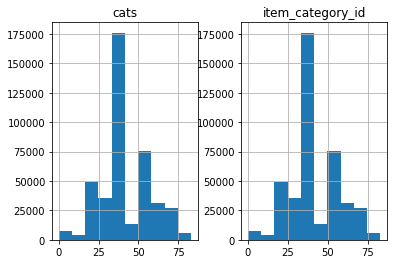

In [44]:
train_cleaned_df[['cats', 'item_category_id']].hist()

In [ ]:
# train_cleaned_df = train_cleaned_df[['shop_id', 'item_id', 'cats'] + list(range(34))]

### XGBoost

In [57]:
X_cols = ['shop_id', 'item_id', 'item_category_id'] + [i for i in range(33)]
y_col = [33]

X = train_cleaned_df[X_cols].values
y = train_cleaned_df[y_col].values

In [52]:
import xgboost as xgb
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

progress = dict()
xgbtrain = xgb.DMatrix(X, y)
watchlist  = [(xgbtrain,'train-rmse')]

bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(X))
from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(preds, y))
print(rmse)

[10:20:50] WARNING: /workspace/src/learner.cc:328: 
Parameters: { num_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


1.2495792732967035


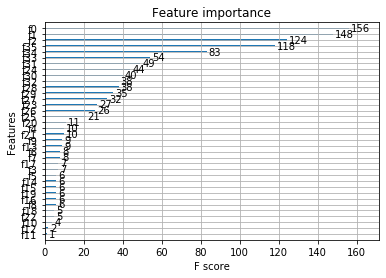

In [53]:
xgb.plot_importance(bst)

### Prediction

In [54]:
test_df = test

In [ ]:
train_cleaned_df.merge(item_to_cat_df, how="inner", on="item_id")

In [56]:

#apply_df['shop_id']= apply_df.shop_id.astype('str')
#apply_df['item_id']= apply_df.item_id.astype('str')

test_df = pd.merge(test_df, train_cleaned_df, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
test_df.head()

,ID,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,item_name,item_category_id,item_category_name,cats
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,"NHL 15 [PS3, русские субтитры]",19.0,Игры - PS3,19.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,"Need for Speed Rivals (Essentials) [PS3, русская версия]",19.0,Игры - PS3,19.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"Need for Speed Rivals (Classics) [Xbox 360, русская версия]",23.0,Игры - XBOX 360,23.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0


In [58]:
# Output


preds = bst.predict(xgb.DMatrix(test_df[X_cols].values))

In [59]:
# down to 20
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))

In [60]:
sub_df = pd.DataFrame({'ID':apply_df.ID,'item_cnt_month': preds })
sub_df.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.274975
std,61834.358168,0.682610
min,0.000000,0.000000
25%,53549.750000,0.109826
50%,107099.500000,0.183396
75%,160649.250000,0.203652
max,214199.000000,20.000000


In [62]:
output_file_path = '../output/Submission_Predict Sales.csv'


sub_df.to_csv(output_file_path, index=False)